In [1]:
import os
import sys
sys.path.append('../')

import numpy as np
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from pprint import pprint
from scipy.optimize import curve_fit

import src.io as sio
import src.preprocessing as spp
import src.fitting as sft

In [2]:
AFM_FOLDER = sio.get_folderpath("20201009_FirstPumpdown")

# Variation of frequency sweeps with pumpdown

## Variation of Q-factor and resonance frequency
Q-factor and fres increase with increasing vacuum

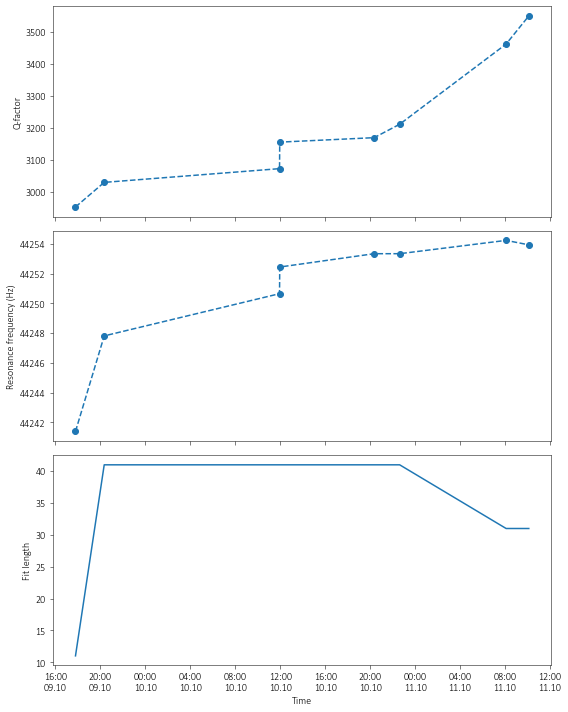

In [25]:
%matplotlib inline
d = spp.get_all_frq_sweeps(AFM_FOLDER, plot=False)
Q = []
f_res = []
dates = []
fitlens = []
for file in d:
    Q.append(d[file]['params']['Q'])
    f_res.append(d[file]['params']['f_res (Hz)'])
    dates.append(datetime.strptime(d[file]['params']['Date'], '%d.%m.%Y %H:%M:%S'))
    fitlens.append(d[file]['params']['Fit length'])

dates = matplotlib.dates.date2num(dates)

fig, (ax1, ax2, ax3)  = plt.subplots(nrows=3, figsize=(8, 10), sharex=True)
ax1.plot_date(dates, Q, "o--")
ax1.set_ylabel("Q-factor")

ax2.plot_date(dates, f_res, "o--")
date_form = DateFormatter("%H:%M\n%d.%m")
ax2.xaxis.set_major_formatter(date_form)
ax2.set_ylabel("Resonance frequency (Hz)")
fig.tight_layout()

ax3.plot(dates, fitlens)
ax3.xaxis.set_major_formatter(date_form)
ax3.set_ylabel('Fit length')
ax3.set_xlabel("Time")

fig.tight_layout()
sio.savefig("Varation_of_q_and_fres_fitlen_with_vacuum")